**Treinamento do Agente no Ambiente CartPole**

O objetivo deste experimento é treinar um agente de aprendizado por reforço profundo (Deep Q-Learning) para resolver o ambiente CartPole-v1, disponível no Gymnasium.

🎯 **Objetivo do Ambiente**

* O agente deve equilibrar o pêndulo (pole) em cima do carrinho (cart) o maior
tempo possível.

* A cada passo em que o pêndulo continua em pé, o agente recebe +1 ponto de recompensa.

O episódio termina quando:

* O pêndulo cai além de um certo ângulo,

* O carrinho sai dos limites da pista, ou é atingido o número máximo de passos.

🧠 **O que o agente aprende**

O agente utiliza uma rede neural (Q-Network) para aproximar a função de valor Q(s, a), que indica o quão boa é cada ação em determinado estado.

* **Estado:** posição do carrinho, velocidade, ângulo da haste, velocidade angular → todos valores reais (contínuos).

* **Ações:** empurrar para esquerda ou para direita → apenas 2 opções discretas.

* Inicialmente, as ações são escolhidas de forma aleatória (exploração).

* Com o tempo, o agente passa a escolher cada vez mais as ações que levam a maiores recompensas (exploration vs. exploitation balanceada com epsilon-greedy).

* Um replay buffer é utilizado para armazenar experiências passadas, de onde são amostrados minibatches para treinar a rede.

📈 **O que esperamos do treinamento**

* No início, as recompensas por episódio serão baixas (o agente não sabe jogar).

* Com o avanço dos episódios, o agente deve aprender a equilibrar o pêndulo por mais tempo, aumentando a recompensa média.

* Após algumas centenas de episódios, o agente deve atingir recompensas próximas ao limite máximo.

In [5]:
import gymnasium as gym      # Importa a biblioteca Gymnasium para ambientes de RL (substituta do OpenAI Gym)
import numpy as np           # Importa o NumPy para operações numéricas e vetoriais
import tensorflow as tf      # Importa o TensorFlow, framework de deep learning
from tensorflow import keras # Atalho para a API Keras dentro do TensorFlow
import matplotlib.pyplot as plt  # Importa o Matplotlib para gráficos

# === Ambiente ===
env = gym.make("CartPole-v1")    # Cria o ambiente CartPole-v1
num_actions = env.action_space.n # Número de ações possíveis no ambiente (discreto: esquerda/direita)
state_shape = env.observation_space.shape  # Formato do vetor de estado (ex.: (4,) para CartPole)

# === Modelo Q-Network ===
def create_q_model():
    # Define uma rede neural para aproximar a função Q(s, a)
    return keras.Sequential([
        keras.layers.InputLayer(state_shape),          # Camada de entrada com o shape do estado
        keras.layers.Dense(128, activation="relu"),    # Camada oculta 1 com 128 neurônios e ReLU
        keras.layers.Dense(128, activation="relu"),    # Camada oculta 2 com 128 neurônios e ReLU
        keras.layers.Dense(num_actions, activation="linear"), # Saída com Q-valor por ação (linear)
    ])

model = create_q_model()                 # Instancia a rede principal (online)
target_model = create_q_model()          # Instancia a rede alvo (target)
target_model.set_weights(model.get_weights())  # Copia pesos da rede principal para a rede alvo

optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Otimizador Adam com taxa de aprendizado 1e-3
loss_fn = keras.losses.Huber()                           # Função de perda Huber (estável a outliers)

# === Replay buffer ===
action_history, state_history, state_next_history, rewards_history, done_history = [], [], [], [], []
# ↑ Buffers para armazenar transições (s, a, r, s', done) e amostrar minibatches

batch_size = 32                  # Tamanho do minibatch para treino
gamma = 0.99                     # Fator de desconto (peso para recompensas futuras)
max_steps_per_episode = 100      # Limite de passos por episódio (para truncar episódios muito longos)

# === Epsilon-greedy ===
epsilon = 1.0                    # Epsilon inicial: começa totalmente exploratório (100% aleatório)
epsilon_min = 0.1                # Epsilon mínimo: não baixa abaixo disso (sempre alguma exploração)
epsilon_decay = 0.995            # Fator de decaimento multiplicativo do epsilon por episódio


# === Treinamento ===
episodes = 150                  # Número total de episódios de treino
running_rewards = []            # Lista para salvar a recompensa total de cada episódio

for ep in range(episodes):      # Loop principal de treinamento, para cada episódio
    state, _ = env.reset()      # Reinicia o ambiente e pega o estado inicial
    episode_reward = 0          # Inicializa a recompensa acumulada do episódio

    for t in range(max_steps_per_episode):   # Loop por passo dentro do episódio
        # Escolha de ação
        if np.random.rand() < epsilon:       # Exploração: escolhe ação aleatória com probabilidade epsilon
            action = np.random.choice(num_actions)
        else:                                # Exploração menor / Exploração guiada (Exploit)
            state_tensor = tf.expand_dims(tf.convert_to_tensor(state), 0)  # Converte estado para tensor
            q_values = model(state_tensor, training=False)  # Predição da rede Q
            action = int(tf.argmax(q_values[0]).numpy())    # Escolhe a ação com maior Q-valor

        # Passo no ambiente
        next_state, reward, done, _, _ = env.step(action)  # Executa ação no ambiente
        episode_reward += reward                           # Soma recompensa ao total do episódio

        # Armazena no buffer de replay
        action_history.append(action)          # Ação escolhida
        state_history.append(state)            # Estado atual
        state_next_history.append(next_state)  # Próximo estado
        rewards_history.append(reward)         # Recompensa recebida
        done_history.append(done)              # Indicador de término do episódio
        state = next_state                     # Atualiza o estado para o próximo passo

        # Treino do modelo (só acontece se já houver amostras suficientes no buffer)
        if len(done_history) > batch_size:
            # Amostra aleatória de transições do buffer
            indices = np.random.choice(len(done_history), size=batch_size)
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = np.array([rewards_history[i] for i in indices])
            action_sample = np.array([action_history[i] for i in indices])
            done_sample = np.array([float(done_history[i]) for i in indices])

            # Predição dos Q-valores futuros (usando target_model)
            future_rewards = target_model.predict(state_next_sample, verbose=0)
            # Calcula valores-alvo: recompensa + desconto * melhor Q futuro (se não for terminal)
            updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1) * (1 - done_sample)

            # Cria máscara one-hot para selecionar apenas as ações tomadas
            masks = tf.one_hot(action_sample, num_actions)

            # Calcula a perda com Gradiente Descendente
            with tf.GradientTape() as tape:
                q_values = model(state_sample)                 # Q-valores previstos pelo modelo
                q_action = tf.reduce_sum(q_values * masks, axis=1)  # Seleciona Q da ação escolhida
                loss = loss_fn(updated_q_values, q_action)     # Perda Huber entre alvo e previsão

            # Calcula gradientes e aplica atualização dos pesos
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if done:  # Se o episódio acabou (pole caiu ou limite de tempo atingido)
            break

    # Atualiza os pesos da target network a cada 10 episódios
    if ep % 10 == 0:
        target_model.set_weights(model.get_weights())

    # Decai o epsilon (menos exploração ao longo do tempo)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Guarda a recompensa total do episódio
    running_rewards.append(episode_reward)
    print(f"Episode {ep+1}: Reward = {episode_reward}")  # Mostra desempenho

Episode 1: Reward = 18.0
Episode 2: Reward = 17.0
Episode 3: Reward = 30.0
Episode 4: Reward = 16.0
Episode 5: Reward = 14.0
Episode 6: Reward = 25.0
Episode 7: Reward = 18.0
Episode 8: Reward = 38.0
Episode 9: Reward = 32.0
Episode 10: Reward = 21.0
Episode 11: Reward = 48.0
Episode 12: Reward = 12.0
Episode 13: Reward = 21.0
Episode 14: Reward = 35.0
Episode 15: Reward = 17.0
Episode 16: Reward = 32.0
Episode 17: Reward = 22.0
Episode 18: Reward = 15.0
Episode 19: Reward = 18.0
Episode 20: Reward = 13.0
Episode 21: Reward = 19.0
Episode 22: Reward = 15.0
Episode 23: Reward = 19.0
Episode 24: Reward = 39.0
Episode 25: Reward = 13.0
Episode 26: Reward = 19.0
Episode 27: Reward = 13.0
Episode 28: Reward = 15.0
Episode 29: Reward = 31.0
Episode 30: Reward = 18.0
Episode 31: Reward = 34.0
Episode 32: Reward = 36.0
Episode 33: Reward = 14.0
Episode 34: Reward = 21.0
Episode 35: Reward = 14.0
Episode 36: Reward = 17.0
Episode 37: Reward = 18.0
Episode 38: Reward = 27.0
Episode 39: Reward = 

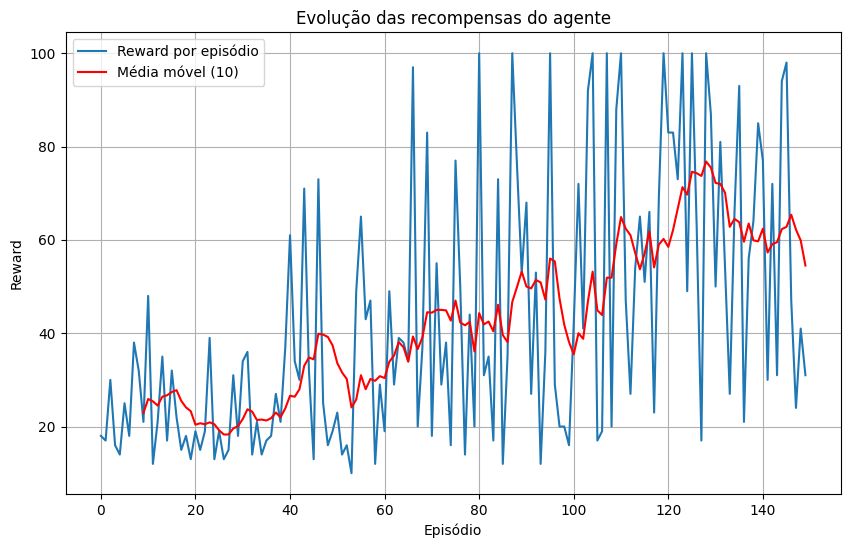

In [6]:
# === Plot e salva gráfico ===
window = 10
smoothed_rewards = np.convolve(running_rewards, np.ones(window)/window, mode='valid')
plt.figure(figsize=(10,6))
plt.plot(running_rewards, label='Reward por episódio')
plt.plot(range(window-1, len(running_rewards)), smoothed_rewards, label=f'Média móvel ({window})', color='red')
plt.xlabel('Episódio')
plt.ylabel('Reward')
plt.title('Evolução das recompensas do agente')
plt.legend()
plt.grid(True)
plt.savefig('evolucao_rewards.png', dpi=300)
plt.show()

In [7]:
import imageio   # Biblioteca para manipulação de imagens e vídeos (criar GIFs/MP4 a partir de frames)

# Cria o ambiente CartPole configurado para renderizar em formato de imagem (RGB array)
env = gym.make("CartPole-v1", render_mode="rgb_array")

frames = []  # Lista onde serão armazenados os frames do vídeo

N_EPISODES = 3  # Número de episódios que vamos gravar

for ep in range(N_EPISODES):     # Loop para rodar e gravar cada episódio
    state, _ = env.reset()       # Reseta o ambiente para o início do episódio
    done = False                 # Flag para indicar se o episódio terminou

    while not done:              # Executa até o episódio acabar
        # Escolhe ação de forma greedy (sempre pega a ação com maior Q-valor, sem exploração)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)  # Converte estado em tensor float32
        state_tensor = tf.expand_dims(state_tensor, 0)                # Adiciona dimensão batch (necessário p/ modelo)
        q_values = model(state_tensor, training=False)                # Predição da rede Q
        action = int(tf.argmax(q_values[0]).numpy())                  # Escolhe a ação com maior Q-valor

        # Executa a ação escolhida no ambiente
        state, reward, done, _, _ = env.step(action)

        # Renderiza o ambiente e captura a imagem do frame
        frame = env.render()
        frames.append(frame)   # Salva o frame na lista

env.close()  # Fecha o ambiente (boa prática para liberar recursos)

# Salva todos os frames em um único vídeo MP4
imageio.mimsave("cartpole_dqn.mp4", frames, fps=30)

print("Vídeo salvo como cartpole_dqn.mp4")  # Mensagem de confirmação

Vídeo salvo como cartpole_dqn.mp4


In [8]:
from IPython.display import Video

# Caminho local ou URL
Video("/content/cartpole_dqn.mp4", embed=True, width=600, height=400)